In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dataset = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test_dataset = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

pd.options.display.float_format = '{:.3f}'.format # Set display option for 3 decimal places

In [4]:
#Dropping duplicates
# duplicated_rows = train_dataset[train_dataset.duplicated(keep=False)]
# print(f"Duplicated values (before dropping): {duplicated_rows.sum()}")
train_dataset.drop_duplicates(inplace=True)
# print(f"Duplicated values (after dropping): {train_dataset.duplicated().sum()}")

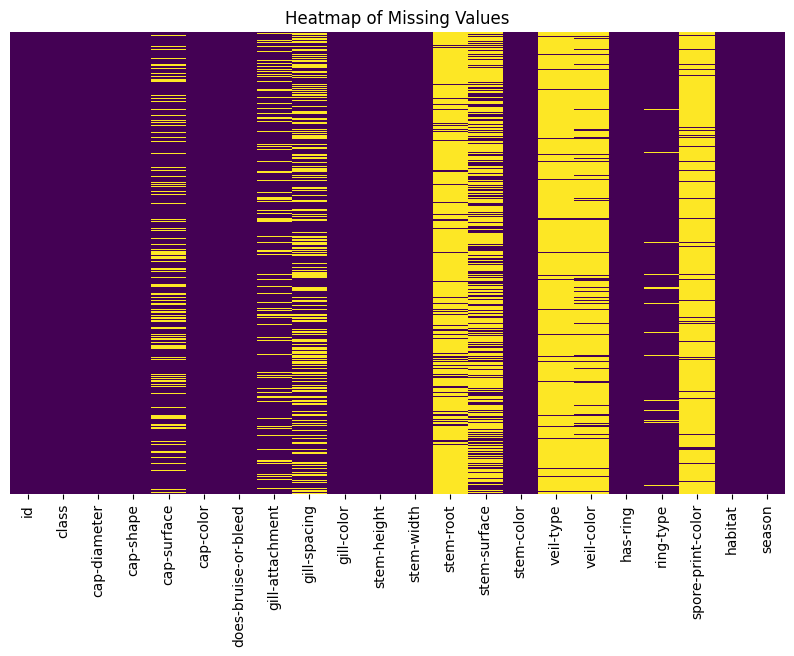

In [5]:
# Create a heatmap to visualize the null values
plt.figure(figsize=(10, 6))
sb.heatmap(train_dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

In [27]:
train_dataset.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [6]:
# Impute missing numerical values
train_dataset['cap-diameter'].fillna(train_dataset['cap-diameter'].mean(), inplace=True)  # Fill with mean
# train_dataset['stem-height'].fillna(train_dataset['stem-height'].median(), inplace=True)  # Fill with median
# train_dataset['stem-width'].fillna(0, inplace=True)  # Fill with a specific value

In [7]:
#dropping following columns because of missing values
# train_dataset.drop(['stem-root','stem-surface','veil-type','veil-color', 'spore-print-color'], axis=1,inplace=True)

#Impute missing Categorical columns
train_df_col_names = train_dataset.select_dtypes(include="object").columns
# print(train_df_col_names)
for col_name in train_df_col_names:
    train_dataset[col_name].fillna('na', inplace=True)

In [8]:
#Cardinality of categorical columns
for col_name in train_df_col_names:
#     train_dataset[col_name].fillna("na", inplace=True)
    print(f"{col_name} : {len(train_dataset[col_name].unique())}")

class : 2
cap-shape : 75
cap-surface : 84
cap-color : 79
does-bruise-or-bleed : 27
gill-attachment : 79
gill-spacing : 49
gill-color : 64
stem-root : 39
stem-surface : 61
stem-color : 60
veil-type : 23
veil-color : 25
has-ring : 24
ring-type : 41
spore-print-color : 33
habitat : 53
season : 4


In [9]:
X = train_dataset.drop(['id', 'class'], axis=1)
y = train_dataset['class']

In [10]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train = X
y_train = y

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
# y_test = label_encoder.transform(y_test)

In [12]:
import category_encoders as ce
target_encoder = ce.TargetEncoder(cols= train_df_col_names.drop('class'))
X_train = target_encoder.fit_transform(X_train, y_train)
# X_test = target_encoder.transform(X_test)

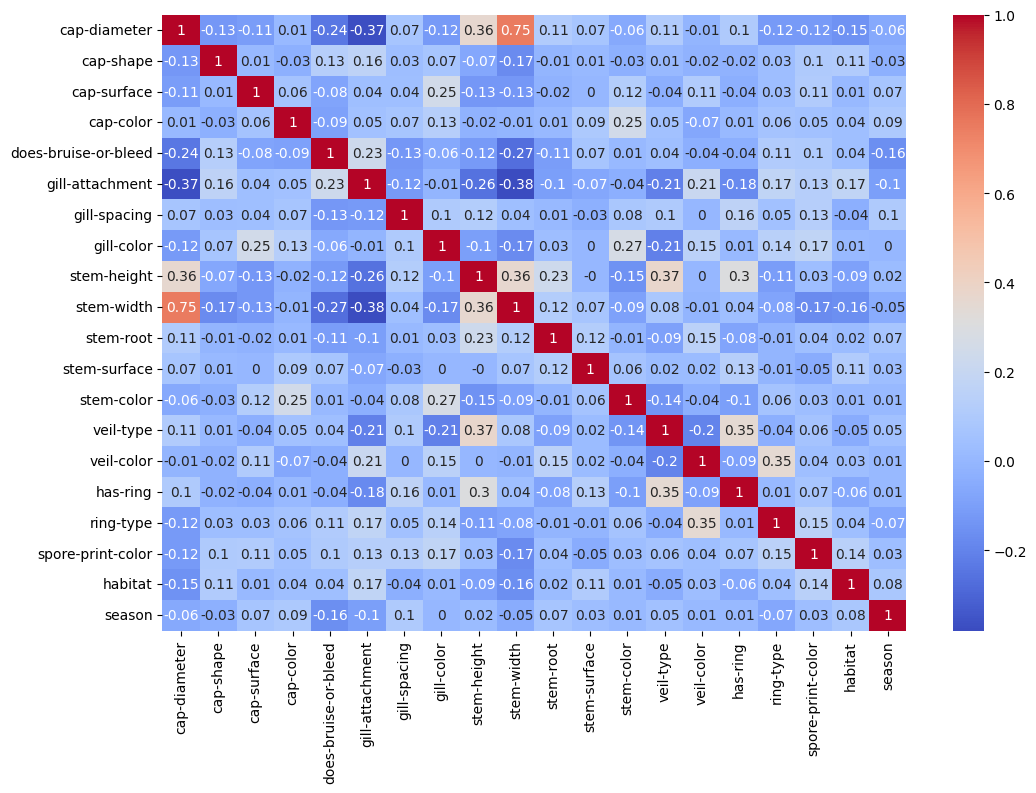

In [13]:
correlation_matrix = X_train.corr().round(2)

plt.figure(figsize=(12, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
# stem-width and cap-diameter are highly correlated 

In [14]:
#Feature scaling is not necessary for a random forest classifier. But it slighly increase the accuracy
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_cols = ['cap-diameter','stem-height', 'stem-width']
ct = ColumnTransformer(transformers=[('feature_scaler', StandardScaler(), numerical_cols)] , remainder='passthrough' )

X_train = ct.fit_transform(X_train)
# X_test = ct.transform(X_test)

## XGB Model

In [15]:
from xgboost import XGBClassifier

Xparams_s1 = {'n_estimators': 948,
           'max_depth': 12,
           'learning_rate': 0.025559161851111477, 
           'reg_alpha': 0.7178566258816612, 
           'reg_lambda': 0.00029868510908985876,
           'subsample': 0.7997054056983265, 
           'colsample_bytree': 0.5013225770330585}

Xparams_s2 = {'n_estimators': 1396, 'max_depth': 19, 'learning_rate': 0.010455050159676566, 'subsample': 0.8006842727555243, 
  'colsample_bytree': 0.5001438770455072, 'colsample_bylevel': 0.8027576507794217, 'min_child_weight': 5,
  'reg_alpha': 1.1586967014672253e-08, 'reg_lambda': 3.3517458803447213e-06, 'gamma': 0.01841032988451454}

# xgb_clf = XGBClassifier(n_estimators=1000)
xgb_clf = XGBClassifier(**Xparams_s2, tree_method='gpu_hist')

history = xgb_clf.fit(X_train, y_train)

In [20]:
y_pred = xgb_clf.predict(X_test)

In [21]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
print(conf_matrix)

[[0.99186796 0.00813204]
 [0.00845553 0.99154447]]


In [22]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)

0.9832298271562303

## Submission set

In [16]:
# Impute missing numerical values
test_dataset['cap-diameter'].fillna(test_dataset['cap-diameter'].mean(), inplace=True)  # Fill with mean
test_dataset['stem-height'].fillna(test_dataset['stem-height'].mean(), inplace=True)
test_dataset['stem-width'].fillna(test_dataset['stem-width'].mean(), inplace=True)

test_df_col_names = test_dataset.select_dtypes(include="object").columns
# print(test_df_col_names)
for col_name in test_df_col_names:
    test_dataset[col_name].fillna('na', inplace=True)

In [17]:
#Finding cardinality of categorical columns
for col_name in test_df_col_names:
#     train_dataset[col_name].fillna("na", inplace=True)
    print(f"{col_name} : {len(test_dataset[col_name].unique())}")

cap-shape : 63
cap-surface : 60
cap-color : 58
does-bruise-or-bleed : 23
gill-attachment : 67
gill-spacing : 36
gill-color : 57
stem-root : 32
stem-surface : 55
stem-color : 56
veil-type : 16
veil-color : 24
has-ring : 24
ring-type : 37
spore-print-color : 34
habitat : 40
season : 4


In [18]:
X_submission = test_dataset.drop(['id'], axis=1)

In [19]:
X_submission_encoded = target_encoder.transform(X_submission)
X_submission_encoded_scaled = ct.transform(X_submission_encoded)

In [20]:
pred = xgb_clf.predict(X_submission_encoded_scaled)

In [21]:
predictions = label_encoder.inverse_transform(pred)
y_pred = pd.DataFrame({'id': test_dataset['id'], 'class': predictions})
y_pred.to_csv('submission_xgboost.csv', index=False)

## Cat Boost

In [ ]:
from catboost import CatBoostClassifier

ctb_clf = CatBoostClassifier()
history = ctb_clf.fit(X_train, y_train, )

In [ ]:
y_pred_ctb = ctb_clf.predict(X_test)
matthews_corrcoef(y_test, y_pred_ctb )